# Bayesian Inference in Practice: Mock Data Sample

In this notebook we will carry out a complete data science project using a mock data sample: Boston Housing data sample. Cliche and frowned upon to use these types of datasets, this notebook is a first attempt at demonstrating understanding of the concepts associated with Bayesian inference.

Some of the code and notes were taken from William Koehrsen's Jupyter notebook on Bayesian inference, which you can find [here](https://github.com/WillKoehrsen/Data-Analysis/blob/master/bayesian_lr/Bayesian%20Linear%20Regression%20Project.ipynb).

In [ ]:
# Imports
# The usual suspects ...
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Distributions
import scipy as sp

# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats

# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.datasets import load_boston

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Warning
from warnings import filterwarnings

# Settings
filterwarnings('ignore')
%matplotlib inline
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)

In [2]:
# Loading the data
boston = load_boston()
df = pd.DataFrame(data=boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

##### Notes
Characteristics:
>- **Number of Instances:** 506
>- **Number of Attributes:** 13
>- Median Value (variable 14) is usually the target.

Variables:
>1. **CRIM** - per capita crime rate by town.
>2. **ZN** - proportion of residential land zoned for lots over 25,000 sq.ft.
>3. **INDUS** - proportion of non-retail business acres per town.
>4. **CHAS** - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
>5. **NOX** - nitric oxides concentration (parts per 10 million).
>6. **RM** - average number of rooms per dwelling.
>7. **AGE** - proportion of owner-occupied units built prior to 1940.
>8. **DIS** - weighted distances to five Boston employment centres.
>9. **RAD** - index of accessibility to radial highways.
>10. **TAX** - full-value property-tax rate per USD10,000.
>11. **PTRATIO** - pupil-teacher ratio by town.
>12. **B** - $1000(B_k - 0.63)^2$ where $B_k$ is the proportion of blacks by town.
>13. **LSTAT** - % lower status of the population.
>14. **MEDV** - Median value of owner-occupied homes in USD1000's.

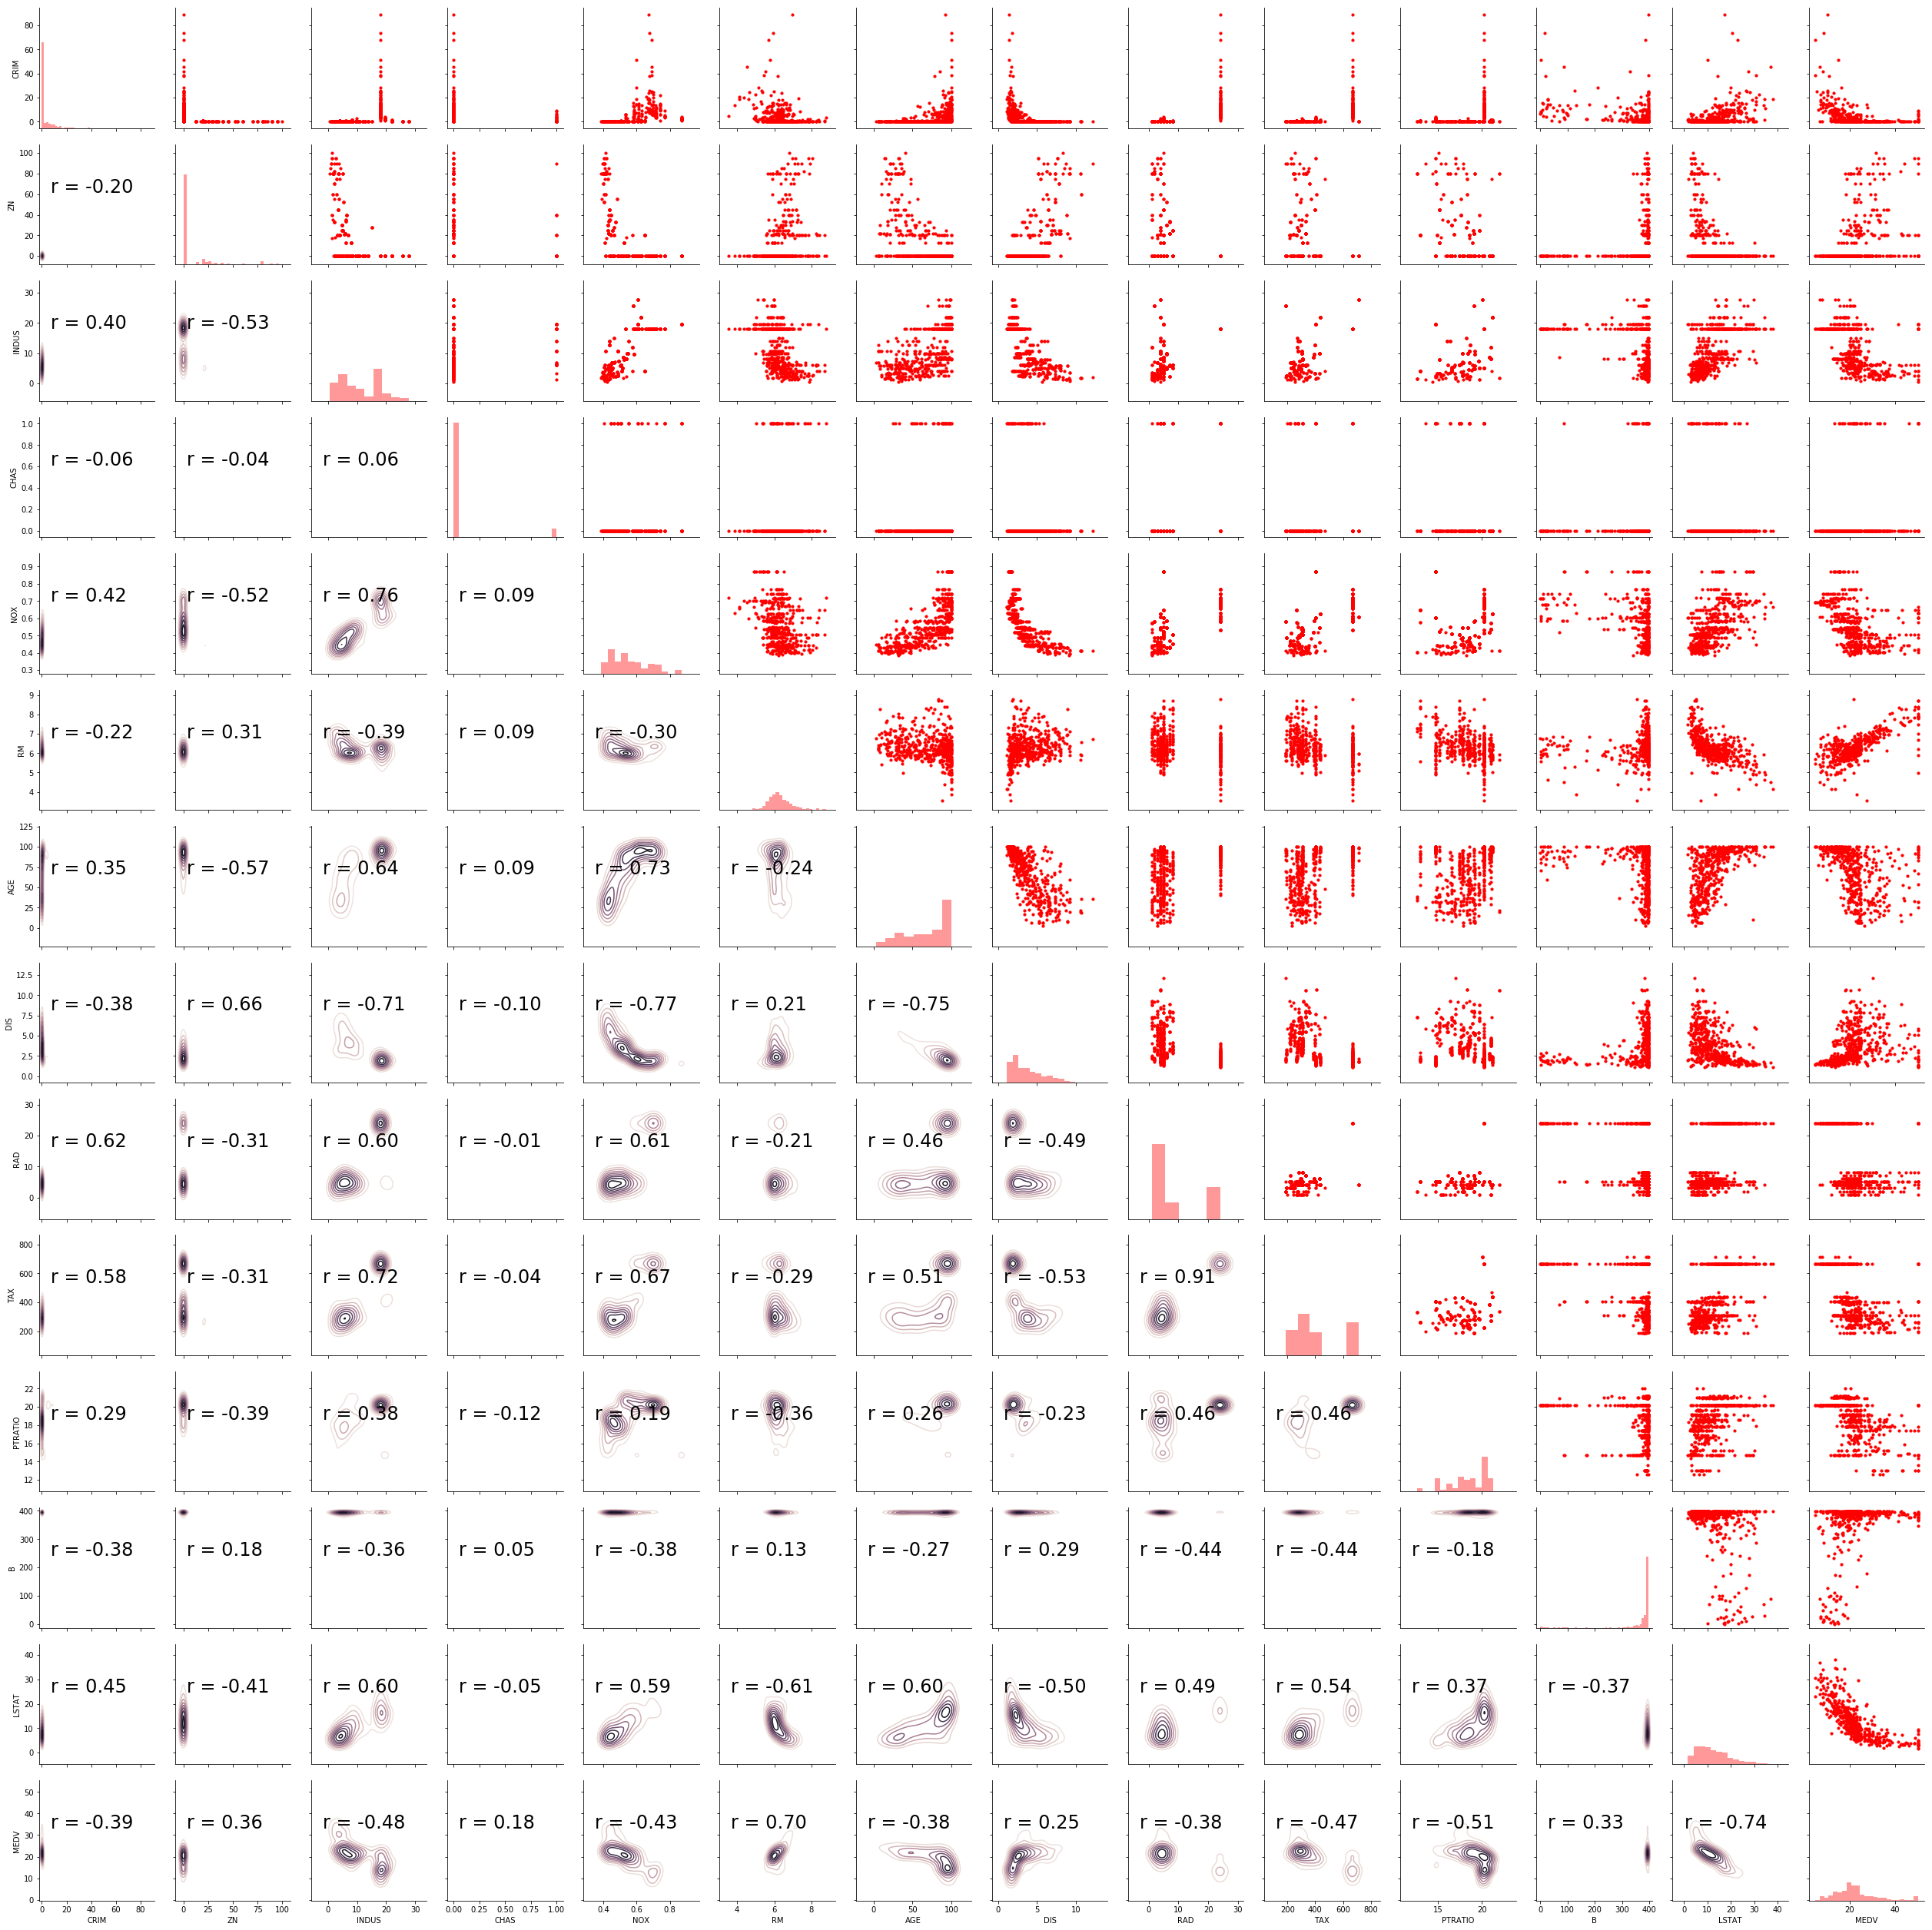

In [3]:
# Calculate correlation coefficients
def corrfunc(x, y, **kws):
    '''Calculate correlation coefficients.'''
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

In [4]:
# Create relation to the target column
df_plot = df.copy()
df_plot['relation_median'] = (df_plot['MEDV'] >= df_plot['MEDV'].median())
df_plot['relation_median'] = df_plot['relation_median'].replace({True: 'above', False: 'below'})
df_plot = df_plot.drop(columns='MEDV')

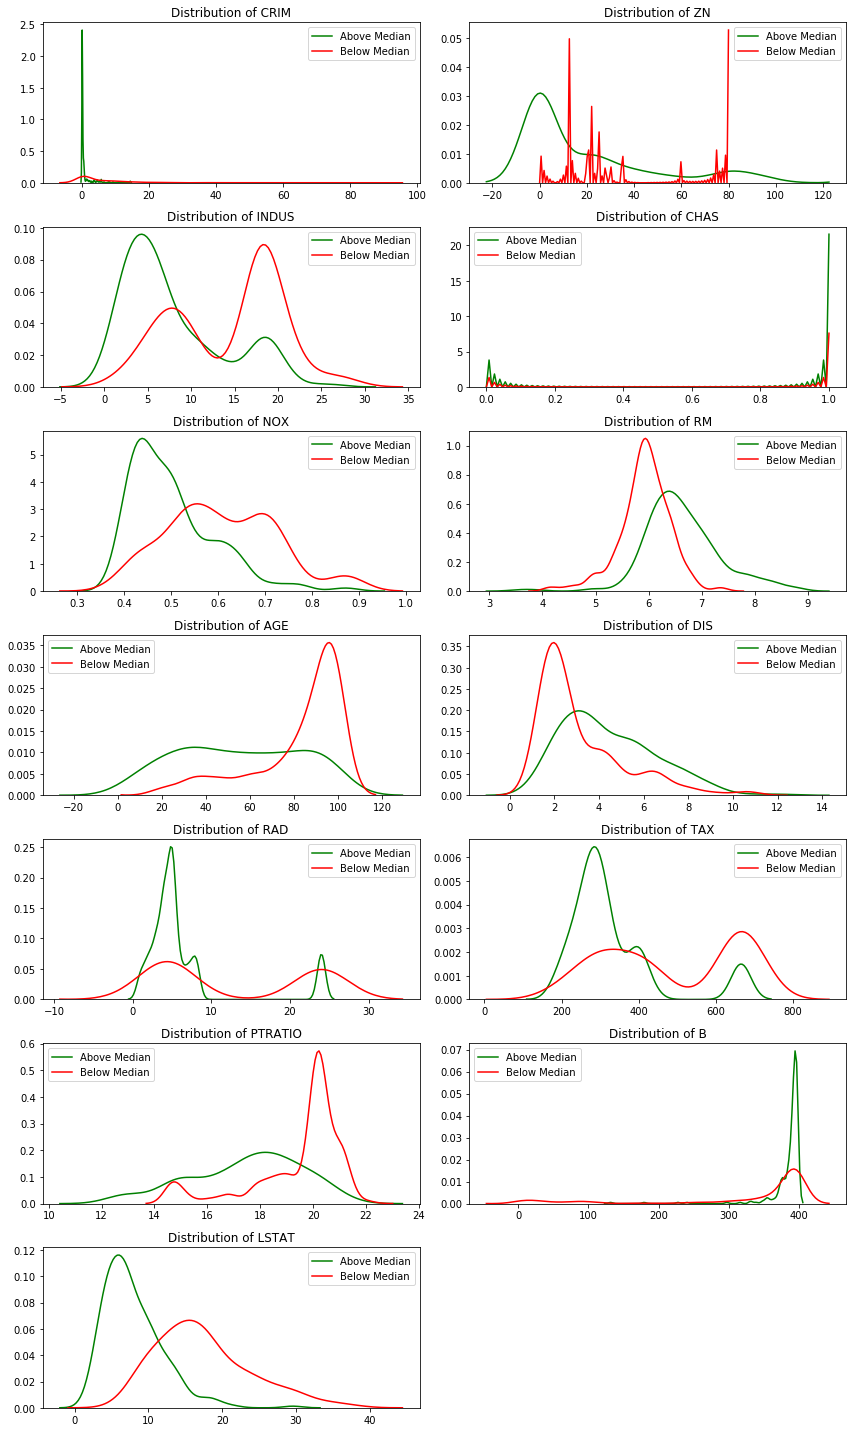

In [5]:
plt.figure(figsize=(12, 20))
# Plot the distribution of each variable colored
# by the relation to the mean property tax
for i, col in enumerate(df_plot.columns[:-1]):
    plt.subplot(7, 2, i + 1)
    subset_above = df_plot[df_plot['relation_median'] == 'above']
    subset_below = df_plot[df_plot['relation_median'] == 'below']
    sns.kdeplot(subset_above[col], label = 'Above Median', color = 'green')
    sns.kdeplot(subset_below[col], label = 'Below Median', color = 'red')
    plt.legend(); plt.title('Distribution of %s' % col)
    
plt.tight_layout()

#### Metrics

This is a regression task and we will use two metrics:

>- Mean Absolute Error (MAE): Average of the absolute value of the difference between predictions and the true values.
>- Root Mean Squared Error (RMSE): The square root of the average of the squared differences between the predictions and the true values.

The MAE is more interpretable, while the RMSE penalizes larger errors more heavily.

In [6]:
# Metrics
def evaluate_predictions(predictions, true):
    '''Calculates the Mean Absolute Error (MAE) & Root Mean Squared Error (RMSE)'''
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))
    return mae, rmse

#### Naive Baseline

For a regression task, a simple naive baseline is to guess the median value on the training set for all testing cases. If our machine learning model cannot better this simple baseline, then we may need to try a different approach.

In [7]:
# Splitting the data
def format_data(df):
    # Target
    labels = df['MEDV']
    
    # Correlations with 'MEDV'
    most_correlated = df.corr().abs()['MEDV'].sort_values(ascending=False)
    
    # Maintain top 6 features that are highly correlated with 'MEDV'
    most_correlated = most_correlated[:7]
    df = df.loc[:, most_correlated.index]
    
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=.25, random_state=42)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = format_data(df)

In [8]:
# Naive baseline
median_pred = X_train['MEDV'].median()
median_preds = [median_pred for _ in range(len(X_test))]
true = X_test['MEDV']

In [9]:
# Display the naive baseline metrics
mb_mae, mb_rmse = evaluate_predictions(median_preds, true)
print('Median Baseline  MAE: {:.4f}'.format(mb_mae))
print('Median Baseline RMSE: {:.4f}'.format(mb_rmse))

Median Baseline  MAE: 5.9276
Median Baseline RMSE: 8.3731


#### Standard Machine Learning Models

We'll train and test several machine learning models for comparison with the Bayesian inference model.

In [10]:
# Evaluate machine learning models
def evaluate(X_train, X_test, y_train, y_test):
    '''Evaluate the machine learning models for comparison.'''
    # Model names
    model_name_list = ['Linear Regression',
                       'ElasticNet Regression',
                       'Random Forest',
                       'Extra Trees',
                       'SVM',
                       'Gradient Boosted',
                       'Baseline']
    X_train = X_train.drop('MEDV', axis=1)
    X_test = X_test.drop('MEDV', axis=1)
    
    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1., l1_ratio=.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1., gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    
    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse'], index=model_name_list)
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        # Inserting results into the dataframe
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse]
    
    # Median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.loc['Baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

results = evaluate(X_train, X_test, y_train, y_test)

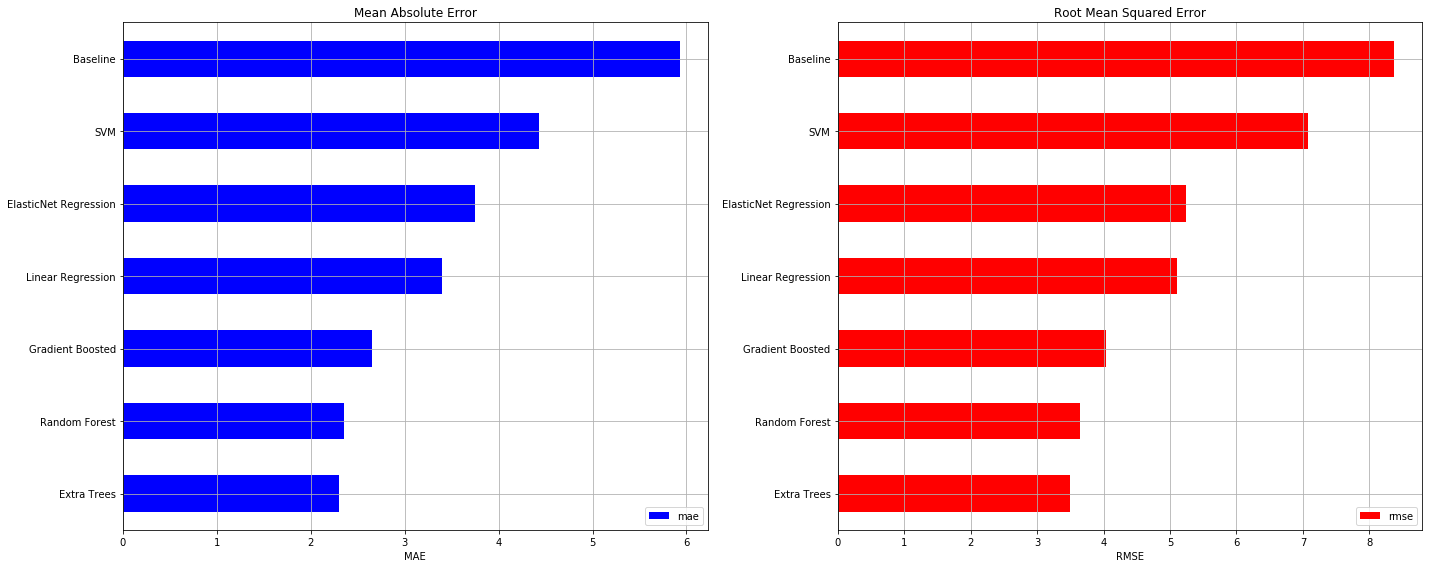

In [11]:
# Visualize results
# RMSE
plt.figure(figsize=(20,8), edgecolor='black')
ax = plt.subplot(1, 2, 1)
results.sort_values('mae', ascending=True).plot.barh(y='mae', color='b', ax=ax)
plt.title('Mean Absolute Error')
plt.xlabel('MAE')
plt.grid()

# MAE
ax = plt.subplot(1, 2, 2)
results.sort_values('rmse', ascending=True).plot.barh(y='rmse', color='r', ax=ax)
plt.title('Root Mean Squared Error')
plt.xlabel('RMSE')
plt.grid()

plt.tight_layout()

In [12]:
print('The Gradient Boosted regressor is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['Gradient Boosted', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))
print('The Support Vector Machine is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['SVM', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))
print('The Extra Trees are {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['Extra Trees', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))
print('The Random Forest is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['Random Forest', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))
print('The ElasticNet Regression is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['ElasticNet Regression', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))
print('The LinearRegression is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['Linear Regression', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))

The Gradient Boosted regressor is 55.32% better than the baseline.
The Support Vector Machine is 25.32% better than the baseline.
The Extra Trees are 61.16% better than the baseline.
The Random Forest is 60.21% better than the baseline.
The ElasticNet Regression is 36.68% better than the baseline.
The LinearRegression is 42.71% better than the baseline.


#### Ordinary Least Squares (OLS) Regression

In [13]:
# OLS formula
lr = LinearRegression()
lr.fit(X_train.drop('MEDV', axis=1), y_train)
ols_formula = 'MEDV = %.2f +' % lr.intercept_
for i, col in enumerate(X_train.drop('MEDV', axis=1).columns):
    ols_formula += ' %.2f * %s +' % (lr.coef_[i], col)
' '.join(ols_formula.split(' ')[:-1])

'MEDV = 15.57 + -0.57 * LSTAT + 4.96 * RM + -0.82 * PTRATIO + 0.12 * INDUS + -0.00 * TAX + -2.84 * NOX'

#### Implementing Bayesian Linear Regression

In [14]:
# Formula for Bayesian Linear Regression
formula = 'MEDV ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[1:]])
formula

'MEDV ~ LSTAT + RM + PTRATIO + INDUS + TAX + NOX'

#### Create Model in PyMC3 and Sample from Posterior

We now build the model using the formula defined above and a Normal distribution for the data likelihood. Then, we let a Markov Chain Monte Carlo algorithm draw samples from the posterior to approximate the posterior for each of the model parameters.

In [15]:
# Context for the model
with pm.Model() as normal_model:
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula=formula, data=X_train, family=family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=2000, chains=2, tune=1000, njobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, NOX, TAX, INDUS, PTRATIO, RM, LSTAT, Intercept]
100%|██████████| 3000/3000 [00:48<00:00, 62.30it/s] 
The acceptance probability does not match the target. It is 0.8943718073428024, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9205094075107872, but should be close to 0.8. Try to increase the number of tuning steps.


#### Examining Bayesian Linear Regression Results

##### Traceplots of All Samples

In [ ]:
# Trace plots
def plot_trace(trace):
    '''Shows the trace with a vertical line at the mean of the trace.'''
    # Traceplot with vertical lines at the mean value
    ax = pm.traceplot(trace, figsize=(14, len(trace.varnames)*1.8),
                      lines={k: v['mean'] for k, v in pm.trace_to_dataframe(trace).describe().iterrows()}) # Error!
    matplotlib.rcParams['font.size'] = 16
    # Labels with the median value
    for i, mn in enumerate(pm.trace_to_datafmrame(trace).describe()['mean']):
        ax[i, 0].annoate('{:.2f}'.format(mn), xy=(mn, 0), xycoords='data', size=8,
                         xytext=(-18, 18), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='red')
        
plot_trace(normal_trace)

The left side of the traceplot is the marginal posterior: the values for the variable are on the x-axis with the probability for the variable (as determined by sampling) on the y-axis. The different colored lines indicate that we performed two chains of Markov Chain Monte Carlo. From the left side we can see that there is a range of values for each weight. The right side shows the different sample values drawn as the sampling process runs.

Another method built into PyMC3 for examinig trace results is the forestplot which shows the distribution of each sampled parameter. This allows us to see the uncertainty in each sample. The forestplot is easily constructed from the trace using `pm.forestplot`.

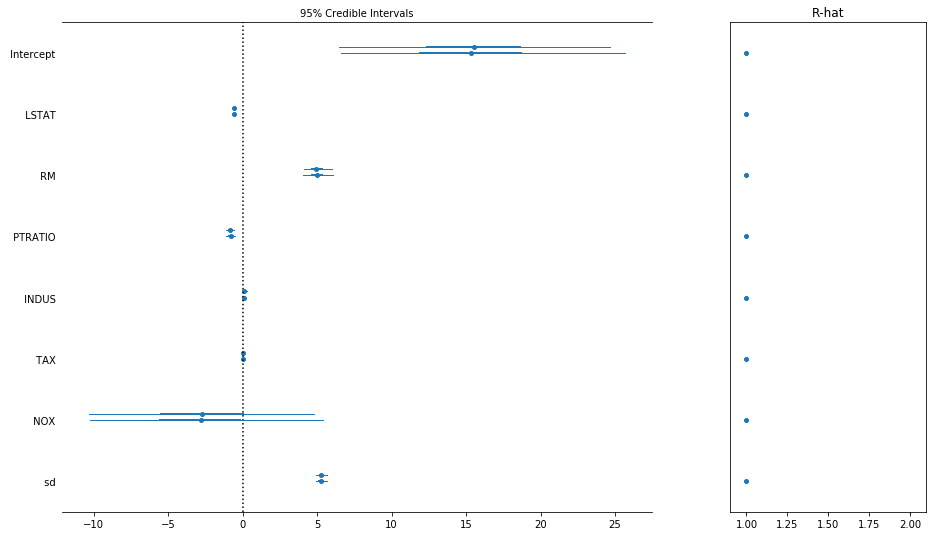

In [16]:
# Forest plot
plt.figure(figsize=(15, 8))
pm.forestplot(normal_trace)

From the forest plot, we can see the most likely value of the parameter (the dot) as well as the 95% credible interval for the parameter. The `intercept` and `NOX` have larger uncertainity compared to the other variables.

Another built-in plotting method in PyMC3 is the posterior distribution of all the model parameters. These histograms allow us to see how  the model result is a distribution of the parameters rather than a single value.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcefe19d9b0>,
      dtype=object)

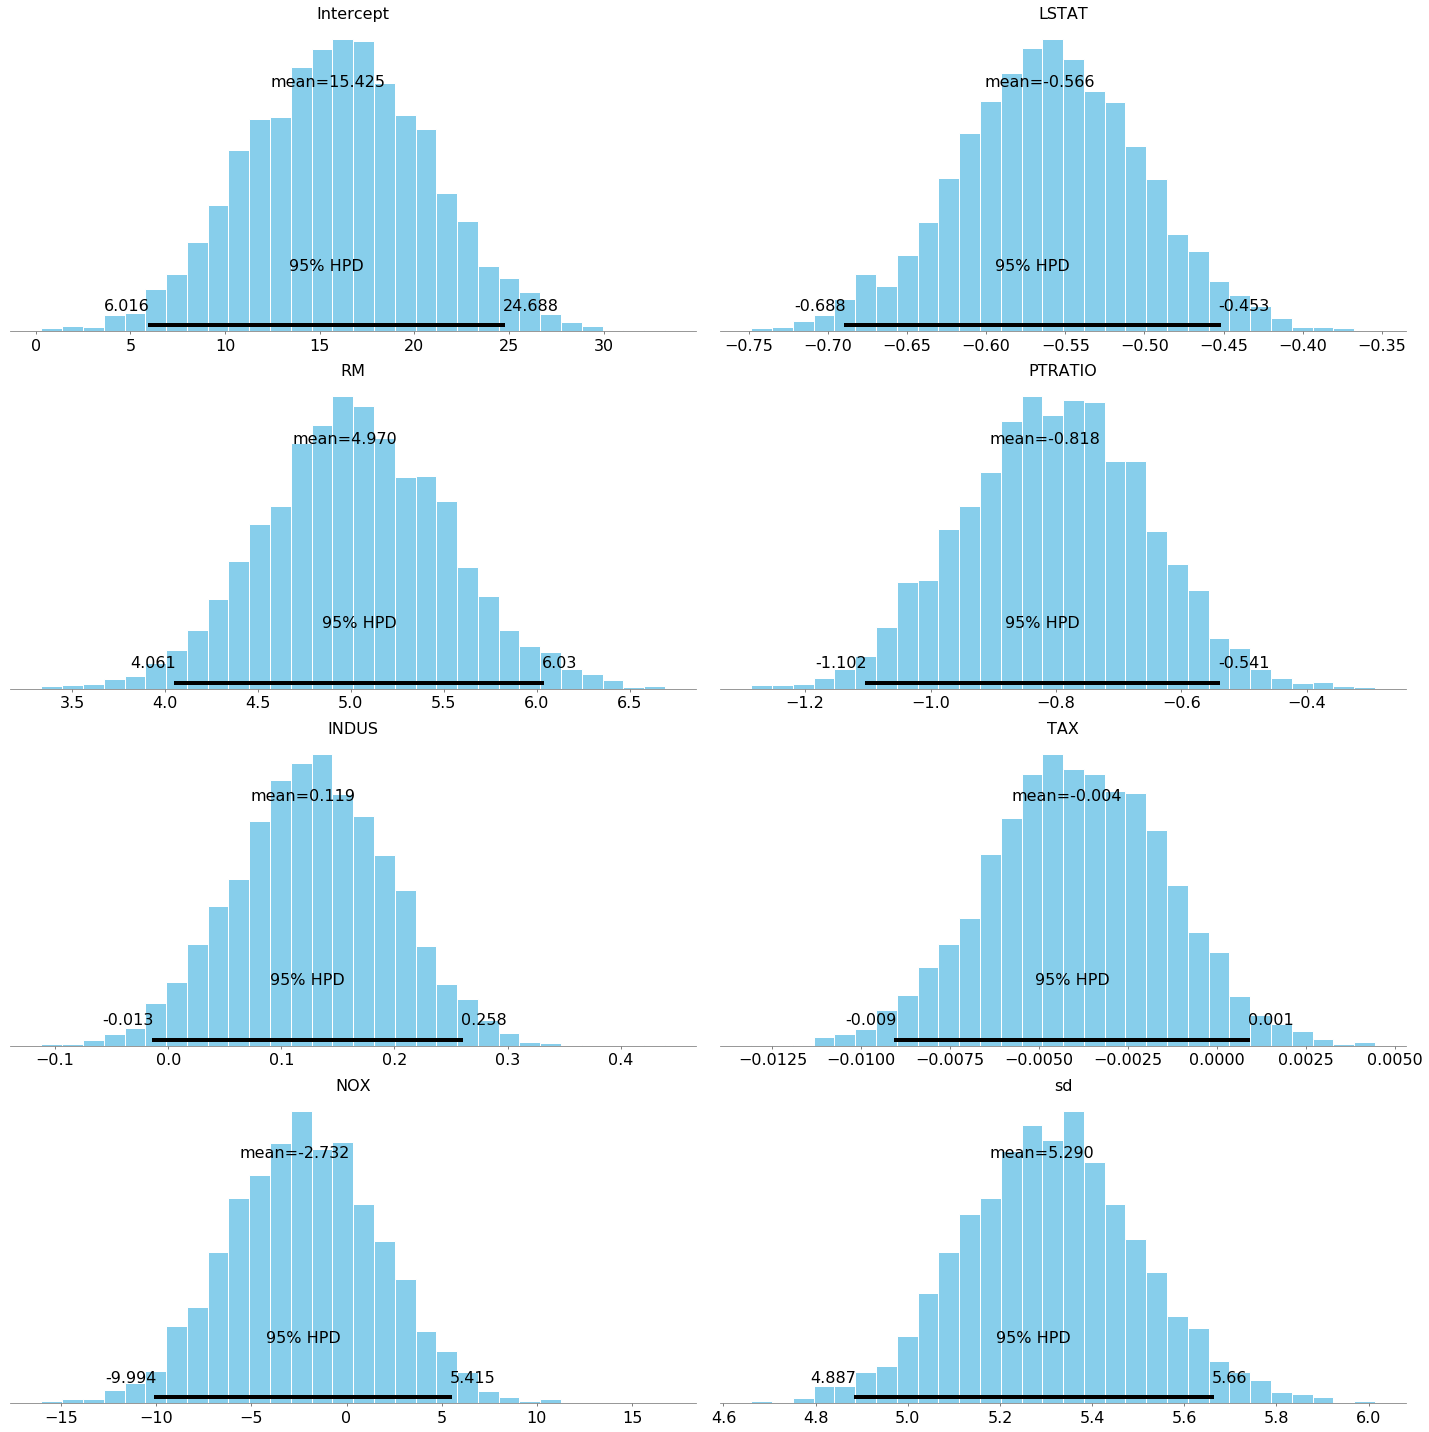

In [17]:
# Posterior distribution
pm.plot_posterior(normal_trace, figsize=(20, 20), text_size=16)

In [18]:
#  Print out the mean variable weight from the trace
for variable in normal_trace.varnames:
    print('Variable: {:15} Mean weight in model: {:.4f}'.format(variable, np.mean(normal_trace[variable])))

Variable: Intercept       Mean weight in model: 15.4251
Variable: LSTAT           Mean weight in model: -0.5663
Variable: RM              Mean weight in model: 4.9700
Variable: PTRATIO         Mean weight in model: -0.8184
Variable: INDUS           Mean weight in model: 0.1189
Variable: TAX             Mean weight in model: -0.0042
Variable: NOX             Mean weight in model: -2.7324
Variable: sd_log__        Mean weight in model: 1.6652
Variable: sd              Mean weight in model: 5.2901


#### Interpretations of Weights

Based on the sign and location of weights, we can make the following inferences regarding the features in the data:

>- Previous LSTAT values are negatively related to MEDV.
>- Higher RM is positively related to MDEV.
>- TAX and NOX are negatively related to MEDV.

In [19]:
pm.trace_to_dataframe(normal_trace).describe().T

count       mean       std        min        25%        50%  \
Intercept  4000.0  15.425126  4.786244  -0.253720  12.153650  15.451757   
LSTAT      4000.0  -0.566319  0.058912  -0.754880  -0.605896  -0.566828   
RM         4000.0   4.969975  0.495787   3.279023   4.646212   4.960359   
PTRATIO    4000.0  -0.818365  0.146245  -1.302392  -0.917660  -0.816666   
INDUS      4000.0   0.118877  0.069401  -0.121375   0.072328   0.118719   
TAX        4000.0  -0.004229  0.002522  -0.013385  -0.005887  -0.004236   
NOX        4000.0  -2.732414  4.000602 -16.582816  -5.499876  -2.763952   
sd         4000.0   5.290070  0.194507   4.637947   5.160099   5.287576   

                 75%        max  
Intercept  18.639389  32.689717  
LSTAT      -0.526759  -0.360957  
RM          5.303554   6.633985  
PTRATIO    -0.715855  -0.308112  
INDUS       0.166330   0.429954  
TAX        -0.002474   0.004149  
NOX        -0.087181  16.186508  
sd          5.413478   5.991126

In [20]:
# Linear formula from Bayesian inference
model_formula = 'MEDV = '
for variable in normal_trace.varnames:
    model_formula += ' %.2f * %s +' % (np.mean(normal_trace[variable]), variable)
' '.join(model_formula.split(' ')[:-1])

'MEDV =  15.43 * Intercept + -0.57 * LSTAT + 4.97 * RM + -0.82 * PTRATIO + 0.12 * INDUS + -0.00 * TAX + -2.73 * NOX + 1.67 * sd_log__ + 5.29 * sd'

#### Evaluate Bayesian Model Using Mean of Model Parameters

In [ ]:
# Evaluate the MCMC trace and compare to machine learning models
def evaluate_trace(trace, X_train, X_test, y_train, y_test, model_results):
    '''Evaluate the MCMC trace and compare to the machine learning models.'''
    # Dictionary of all supplied values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Mean of all weights
    var_means = var_weights.mean(axis=0)
    
    # Create an intercept column
    X_test['Intercept'] = 1
    
    # Align names of the test observations and means
    names = X_test.columns[1:]
    X_test = X_test.loc[:, names]
    var_names = var_means[names]
    
    # Calculate the estimate for each test observation using average weights
    results = pd.DataFrame(index=X_test.index, columns=['estimate'])
    
    for row in X_test.iterrows():
        results.iloc[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1])) # Error!
        
    # Metrics
    actual = np.array(y_test)
    errors = results['estimate'] - actual
    mae = np.mean(abs(errors))
    rmse = np.sqrt(np.mean(errors ** 2))
    
    print('Model MAE: {:.4f}\nModel RMSE: {:.4f}'.format(mae, rmse))
    
    # Add the results to the comparison dataframe
    model_results.loc['Bayesian LR', :] = [mae, rmse]
    plt.figure(figsize=(20, 8))
    
    # Plot Median Absolute Percentage Error of all models
    ax = plt.subplot(1, 2, 1)
    model_results.sort_values('mae', ascending=True).plot.barh(y='mae', color='r', ax=ax)
    plt.title('Model Mean Absolute Error Comparison')
    plt.xlabel('MAE')
    plt.grid()
    
    # Plot Root Mean Squared Error of all models
    ax = plt.subplot(1, 2, 2)
    model_results.sort_values('rmse', ascending=True).plot.barh(y='rmse', color='b', ax=ax)
    plt.title('Model Root Mean Squared Error Comparison')
    plt.xlabel('RMSE')
    plt.grid()
    plt.tight_layout()
    
    return model_results

all_model_results = evaluate_trace(normal_trace, X_train, X_test, y_train, y_test, results)